Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.1**2 * RBF(length_scale=9.54) + WhiteKernel(noise_level=0.00163)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.09**2 * RBF(length_scale=9.44) + WhiteKernel(noise_level=0.00138)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.07**2 * RBF(length_scale=9.29) + WhiteKernel(noise_level=0.00117)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.06**2 * RBF(length_scale=9.71) + WhiteKernel(noise_level=0.00133)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.13**2 * RBF(length_scale=9.92) + WhiteKernel(noise_level=0.00142)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.16**2 * RBF(length_scale=9.29) + WhiteKernel(noise_level=0.00158)
Random Forest entraîné sur 44 obligations.
GP Calibré. Noyau optimal : 1.08**2 * RBF(length_scale=10.4) + WhiteKernel(noise_level=0.00123)
Random Forest entraîné sur 4

,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
5,Gaussian Process,2.842387,2.876208,2.007004,6.258147
1,Svensson,4.218241,2.970214,2.480118,11.952096
4,Random Forest,4.714820,1.452417,3.385394,11.362668
2,Spline Smooth,6.630224,22.338107,3.291370,19.494909
0,Nelson-Siegel,12.804885,15.485095,11.485149,20.592645
3,Spline Interp,14.843957,39.409566,7.397557,40.409126



Pays : Allemagne


,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
2,Spline Smooth,2.213508,0.536851,1.790077,4.592604
5,Gaussian Process,2.226367,0.462810,1.821140,4.293177
4,Random Forest,2.574214,0.622879,2.098293,5.186448
1,Svensson,3.184915,1.393029,2.350790,7.241304
0,Nelson-Siegel,3.343180,0.734815,2.697963,6.523078
3,Spline Interp,3.507579,1.561757,2.656140,7.855993



Pays : Italie


,Model,RMSE mean (bps),RMSE std,MAE mean (bps),Max error mean (bps)
2,Spline Smooth,3.280435,0.513208,2.706884,7.298155
1,Svensson,3.757103,0.659166,3.079839,8.933589
4,Random Forest,3.815000,0.627186,3.069800,8.584928
5,Gaussian Process,3.826545,1.109775,2.889658,10.339634
0,Nelson-Siegel,5.223273,0.982351,4.218480,12.224341
3,Spline Interp,5.233243,0.934328,4.154035,11.799433


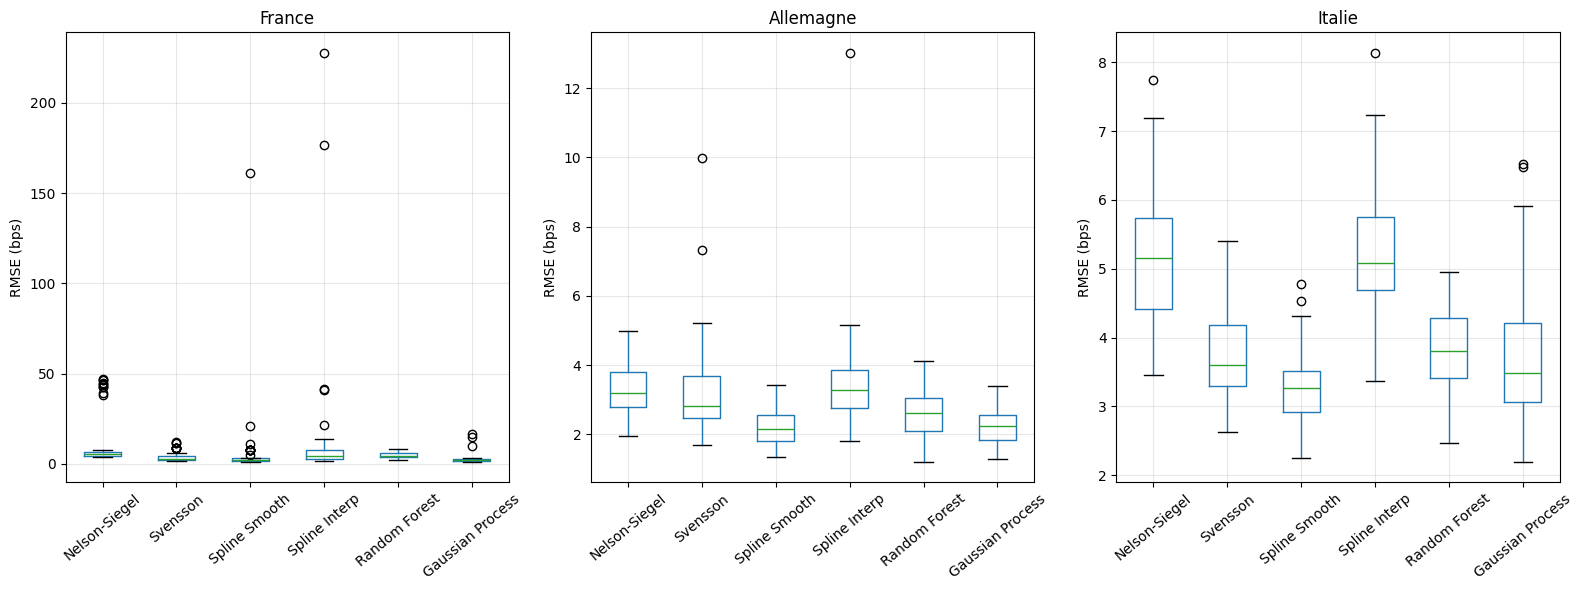

In [1]:
# =========================================================
# PIPELINE COMPLET — ÉVALUATION MODÈLES YIELD CURVE
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import models
from importlib import reload
reload(models)


# =========================================================
# 1. CONFIGURATION
# =========================================================

DATA_PATH = "ML_Ready_Nominal_Dataset.csv"

COUNTRIES = ["France", "Allemagne", "Italie"]

N_SPLITS = 5
N_REPEATS = 10
RANDOM_STATE = 42


# =========================================================
# 2. CHARGEMENT DATA
# =========================================================

df = pd.read_csv(DATA_PATH)

if "TTM" not in df.columns or "Yield" not in df.columns:
    raise ValueError("Dataset doit contenir colonnes TTM et Yield")



# =========================================================
# 3. LISTE MODÈLES
# =========================================================

MODEL_REGISTRY = {
    "Nelson-Siegel": models.NelsonSiegelCurve,
    "Svensson": models.SvenssonCurve,
    "Spline Smooth": lambda: models.CubicSplineCurve(smoothing_factor=1.0),
    "Spline Interp": lambda: models.CubicSplineCurve(smoothing_factor=1e-6),
    "Random Forest": models.RandomForestCurve,
    "Gaussian Process": models.GaussianProcessCurve
}



# =========================================================
# 4. FONCTION FIT + PREDICT UNIFIÉE
# =========================================================

def fit_predict(model_class, train_df, test_df):
    
    model = model_class()
    
    if model_class.__name__ in ["RandomForestCurve","GaussianProcessCurve"]:
        model.fit(train_df)
        pred = model.predict(test_df)
    else:
        model.fit(train_df["TTM"].values, train_df["Yield"].values)
        pred = model.predict(test_df["TTM"].values)
        
    return np.array(pred)



# =========================================================
# 5. ÉVALUATION PRINCIPALE
# =========================================================

results_all = {}
boxplot_data = {c:{m:[] for m in MODEL_REGISTRY} for c in COUNTRIES}

rkf = RepeatedKFold(
    n_splits=N_SPLITS,
    n_repeats=N_REPEATS,
    random_state=RANDOM_STATE
)


for country in COUNTRIES:
    
    df_c = df[df["Country"]==country].sort_values("TTM").reset_index(drop=True)
    
    if len(df_c) < 10:
        print("Pas assez de données pour",country)
        continue
    
    metrics_store = {name:[] for name in MODEL_REGISTRY}
    
    for train_idx, test_idx in rkf.split(df_c):
        
        train_df = df_c.iloc[train_idx]
        test_df  = df_c.iloc[test_idx]
        
        y_true = test_df["Yield"].values
        
        for name, model_cls in MODEL_REGISTRY.items():
            
            try:
                y_pred = fit_predict(model_cls,train_df,test_df)
                
                rmse = np.sqrt(mean_squared_error(y_true,y_pred))
                mae  = mean_absolute_error(y_true,y_pred)
                maxe = np.max(np.abs(y_true-y_pred))
                
                metrics_store[name].append((rmse,mae,maxe))
                boxplot_data[country][name].append(rmse*100)
                
            except Exception as e:
                print(f"Erreur {country} | {name} → {e}")
    
    
    # résumé stats
    summary = []
    
    for name,vals in metrics_store.items():
        arr = np.array(vals)
        
        summary.append({
            "Model":name,
            "RMSE mean (bps)":arr[:,0].mean()*100,
            "RMSE std":arr[:,0].std()*100,
            "MAE mean (bps)":arr[:,1].mean()*100,
            "Max error mean (bps)":arr[:,2].mean()*100
        })
        
    results_all[country] = pd.DataFrame(summary).sort_values("RMSE mean (bps)")


# =========================================================
# 6. TABLEAUX RÉSULTATS
# =========================================================

for country,res in results_all.items():
    print("\n========================")
    print("Pays :",country)
    print("========================")
    display(res)



# =========================================================
# 7. BOXPLOTS COMPARATIFS
# =========================================================

plt.figure(figsize=(16,6))

for i,country in enumerate(COUNTRIES):
    
    plt.subplot(1,len(COUNTRIES),i+1)
    
    data = boxplot_data[country]
    df_box = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
    
    df_box.boxplot(rot=40)
    
    plt.title(country)
    plt.ylabel("RMSE (bps)")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
